### Load Library

In [1]:
#Load library
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import time
from math import sqrt
import random
import matplotlib as matplt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, normalize
from fastFM import als
from sklearn.metrics import mean_absolute_error, mean_squared_error

from surprise import KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate

### Load Data

In [2]:
#Load data
path = "/Users/yh3093/Desktop/Personalization/Final Project/Data/"

#Ratings
ratings = pd.read_csv(path+'ratings.dat', sep='::', header=None, engine='python')
ratings.columns = ['userId','movieId','rating','timestamp']
ratings = ratings.drop('timestamp', axis=1)

#Movies
movies = pd.read_csv(path+'movies.dat', sep='::', header=None, engine='python')
movies.columns = ['movieId','Title','Genres']

#Users
users = pd.read_csv(path+'users.dat', sep='::', header=None, engine='python')
users.columns = ['userId','Gender','Age','Occupation','Zip-code']
users = users.drop('Zip-code', axis=1)

### Data Quality

In [3]:
#Data quality
print('Duplicated rows in ratings file: ' + str(ratings.duplicated().sum()))

n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of movies: {}'.format(n_movies))
print('Sparsity: {:4.3f}%'.format(float(ratings.shape[0]) / float(n_users*n_movies) * 100))

Duplicated rows in ratings file: 0
Number of users: 6040
Number of movies: 3706
Sparsity: 4.468%


### Data Preprocessing

In [4]:
movies.Genres = movies.Genres.str.split('|')

In [5]:
def expand_df(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [6]:
ratings.shape

(1000209, 3)

In [7]:
movies = expand_df(movies, ['Genres'])
movies = movies.drop('Title', axis=1)

In [8]:
ratings = pd.merge(ratings, users, on="userId")

In [9]:
ratings_ffm = ratings.merge(movies, left_on='movieId', right_on='movieId', how='inner')

In [10]:
df_dummy = pd.get_dummies(ratings_ffm['Genres'])

In [11]:
df_new = pd.concat([ratings_ffm, df_dummy], axis=1)

In [12]:
df_final = df_new.groupby(["userId", "movieId", "rating", "Gender", "Age", "Occupation"])[df_new.columns.values[7:]].sum().reset_index()
print(df_final.shape)

(1000209, 24)


### Functions used in training factorization machine

In [13]:
#subset data
def subsetdata(data, by, subset_quantile):
    filter_standard = data.groupby([by]).size().reset_index(name='counts').counts.quantile(subset_quantile)
    subset_data = data.groupby(by).filter(lambda x: len(x) >= filter_standard)
    
    return filter_standard, subset_data

In [14]:
#split train and test data
def split_testtrain(ratings, fraction):
    #Transform data in matrix format
    colnames = ratings.columns.values
    new_colnames = ['1_user', '2_movie', '0_rating', '3_gender', '4_age', '5_occupation', 
                    '6_Action', '7_Adventure', '8_Animation', "9_Children's", '10_Comedy',
                    '11_Crime', '12_Documentary', '13_Drama', '14_Fantasy', '15_Film-Noir', 
                    '16_horror', '17_Musical', '18_Mystery', '19_Romance', '20_Sci-Fi', 
                    '21_Thriller', '22_War', '23_Western']
    ratings = ratings.rename(index=str, columns=dict(zip(colnames, new_colnames)))
    
    ratings_df = ratings.to_dict(orient="records")
    
    dv = DictVectorizer()
    ratings_mat = dv.fit_transform(ratings_df).toarray()
    
    #Split data
    x_train, x_test, y_train, y_test = train_test_split(ratings_mat[:,1:], ratings_mat[:,:1], test_size=fraction)
    
    return x_train, x_test, y_train.T[0], y_test.T[0]

In [15]:
#One hot encoding
def OneHotEncoding(train,test):
    encoder = OneHotEncoder(handle_unknown='ignore').fit(train)
    train = encoder.transform(train)
    test = encoder.transform(test)
    return train, test

In [16]:
#Gridsearch for the optimal parameter
def param_selection(X, y, n_folds):
    start = time.time()
    grid_param = {  
    'n_iter' : np.arange(0,120,25)[1:],
    'rank' :  np.arange(2,12,4),
    }
    grid_search = GridSearchCV(als.FMRegression(l2_reg_w=0.1,l2_reg_V=0.1), cv=n_folds, param_grid=grid_param, verbose=10)
    grid_search.fit(X, y)
    grid_search.best_params_
    print(time.time()-start)
    return grid_search.best_params_

In [17]:
def rec_coverage(x_test, y_test, prediction, rec_num):
    ratings = pd.DataFrame()
    ratings['user'] = x_test[:,0]
    ratings['movie'] = x_test[:,1]
    ratings['rating'] = y_test
    
    pred = ratings.copy()
    pred['rating'] = prediction
    
    rating_table = pd.pivot_table(ratings, index='user', columns = 'movie', values = 'rating')
    pred_table = pd.pivot_table(pred, index='user', columns = 'movie', values = 'rating')
    
    rec_movies = []
    rec = pred_table - rating_table
    for user in rec.index:
            rec_item = pred_table.loc[user,:].sort_values(ascending = False).head(rec_num).index.tolist()
            rec_movies += rec_item
    n_rec = len(set(rec_movies))
    n_movies = pred_table.shape[1]
    coverage = round(float(n_rec)/n_movies,2)
    
    return coverage

In [18]:
def create_plot(x1, x2, x3, y1, y2, y3, kind):
    pal = sns.color_palette("Set2")
    
    matplt.figure.Figure(figsize=(5000,5000))
    plt.plot(x1, y1, c=pal[0], label="Filter-User", linewidth=3)
    plt.plot(x2, y2, c=pal[1], label="Filter-Movie", linewidth=3)
    plt.plot(x3, y3, c=pal[2], label="Filter-Both", linewidth=3)
    plt.legend(loc='best', fontsize=12)
    plt.xticks(fontsize=12);
    plt.yticks(fontsize=12);
    plt.xlabel("Sampled Data Size", fontsize=14);
    plt.ylabel(kind, fontsize=14);
    plt.title(kind, loc='center', fontsize=16);
    plt.show()

### Factorization Machine

In [19]:
def FieldFactorizationMachine(ratings, subset_by, subset_quantile, op_iter, op_rank):
    #Map value
    gender_dict = {"F": 0, "M": 1}
    ratings = ratings.replace({"Gender": gender_dict})
    
    #Initialize output
    final_output = pd.DataFrame()
    result_dict = []
    n_iteration = 1 
    last_RMSE = 100
    threshold = 0
    
    for quantile in subset_quantile:
        print("---Running iteration " + str(n_iteration) + " ---")
        print("---Subsetting Original Data---")
        
        #subset original data
        if subset_by == "user":
            filter_standard, subset_ratings = subsetdata(ratings, "userId", quantile)
        elif subset_by == "movie":
            filter_standard, subset_ratings = subsetdata(ratings, "movieId", quantile)
        else:
            f1, subset_u = subsetdata(ratings, "userId", quantile)
            f2, subset_ratings = subsetdata(subset_u, "movieId", quantile)
            filter_standard = "("+str(f1)+","+str(f2)+")"
        
        n_users = subset_ratings.userId.unique().shape[0]
        n_movies = subset_ratings.movieId.unique().shape[0]
        n_size = subset_ratings.shape[0]*subset_ratings.shape[1]
        
        sparsity = round(float(subset_ratings.shape[0]) / float(n_users*n_movies),2)
        
        print("---Spliting Test and Train Data---")
        #split test and train data
        xtrain, xtest, ytrain, ytest = split_testtrain(subset_ratings, 0.2)

        print("---Encoding Data---")
        #encode data
        xtrain_enc, xtest_enc = OneHotEncoding(xtrain, xtest)
        
       
        start = time.time()
        print("---Factorization Machine---")
        #Factorization machine
        fm = als.FMRegression(n_iter=op_iter, rank=op_rank, l2_reg_w=0.1, l2_reg_V=0.1)
        fm.fit(xtrain_enc, ytrain)
        predictions = fm.predict(xtest_enc)
        spent_time = time.time() - start
        #Evaluation metrics
        rmse = sqrt(mean_squared_error(ytest,predictions))
        mae = mean_absolute_error(ytest,predictions)
        coverage = rec_coverage(xtest, ytest, predictions, 10)
        
        if rmse < last_RMSE:
            last_RMSE = rmse
            threshold = filter_standard
            out = pd.DataFrame()
            out['user'] = xtest[:,0]
            out['movie'] = xtest[:,1]
            out['rating'] = ytest
            out['prediction'] = predictions
            
            final_output = out.copy()
        
        result_dict.append([quantile, filter_standard, n_size, n_users, n_movies, sparsity, op_iter, op_rank, spent_time, mae, rmse, coverage])
        n_iteration += 1
    
    results = pd.DataFrame(result_dict)
    results.columns = ["Quantile", "Threshold", "Size", "Num_Users", "Num_Movies", "Sparsity", "OP_Iter", "OP_Rank", "Running Time", "MAE", "RMSE", "Coverage"]
    
    final_output.to_csv("FFM_Output_"+subset_by+"_"+str(threshold)+".csv", sep=',', encoding='utf-8', index=False)
    
    return results

In [20]:
quantile_list = np.arange(0.1,1,0.1)

### Subset method 1 - Subset data from less prolific users to prolific users

In [21]:
accuracy_matrix_user = FieldFactorizationMachine(df_final, "user", quantile_list, 100, 2)

---Running iteration 1 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 2 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 3 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 4 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 5 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 6 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 7 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running it

In [22]:
accuracy_matrix_user

,Quantile,Threshold,Size,Num_Users,Num_Movies,Sparsity,OP_Iter,OP_Rank,Running Time,MAE,RMSE,Coverage
0,0.1,27.0,23702160,5487,3702,0.05,100,2,139.628221,0.688364,0.877603,1.0
1,0.2,38.0,23203104,4835,3696,0.05,100,2,136.748012,0.684637,0.872970,1.0
2,0.3,51.0,22583304,4247,3689,0.06,100,2,133.654470,0.684583,0.871929,1.0
3,0.4,70.0,21703320,3631,3675,0.07,100,2,123.384483,0.683063,0.870505,1.0
4,0.5,96.0,20512992,3021,3671,0.08,100,2,118.129110,0.681535,0.867517,1.0
5,0.6,126.0,18953952,2429,3669,0.09,100,2,104.969195,0.678930,0.864937,1.0
6,0.7,173.0,16774512,1815,3663,0.11,100,2,91.671748,0.678836,0.864744,1.0
7,0.8,253.0,13771080,1215,3653,0.13,100,2,72.089246,0.677348,0.863175,1.0
8,0.9,400.0,9153768,605,3624,0.17,100,2,43.558324,0.682891,0.871443,1.0


In [23]:
#size_norm_u = normalize(accuracy_matrix_user['Size'][:,np.newaxis], axis=0).ravel()
size_norm_u = 1-np.array(accuracy_matrix_user['Quantile'])

In [24]:
time_u = np.array(accuracy_matrix_user['Running Time'])
mae_u = np.array(accuracy_matrix_user['MAE'])
rmse_u = np.array(accuracy_matrix_user['RMSE'])
coverage_u = np.array(accuracy_matrix_user['Coverage'])

### Subset method 2 - Subset data from less popular items to popular items

In [25]:
accuracy_matrix_movie = FieldFactorizationMachine(ratings, "movie", quantile_list, 25, 2)

---Running iteration 1 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 2 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 3 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 4 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 5 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 6 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 7 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running it

In [26]:
accuracy_matrix_movie

,Quantile,Threshold,Size,Num_Users,Num_Movies,Sparsity,OP_Iter,OP_Rank,Running Time,MAE,RMSE,Coverage
0,0.1,7.0,5995524,6040,3350,0.05,25,2,12.236929,0.689428,0.879453,0.76
1,0.2,23.0,5964618,6040,2976,0.06,25,2,12.064855,0.687384,0.875639,0.81
2,0.3,44.0,5890818,6040,2599,0.06,25,2,11.978348,0.682721,0.869367,0.86
3,0.4,74.0,5764962,6040,2234,0.07,25,2,11.581689,0.688576,0.877720,0.91
4,0.5,123.5,5543334,6040,1853,0.08,25,2,10.961639,0.680661,0.867589,0.95
5,0.6,188.0,5202954,6040,1485,0.10,25,2,10.100358,0.680511,0.867270,0.98
6,0.7,280.0,4689642,6040,1113,0.12,25,2,8.670737,0.678078,0.864230,0.99
7,0.8,429.0,3915810,6040,743,0.15,25,2,6.848009,0.675242,0.862520,1.00
8,0.9,729.5,2667804,6039,371,0.20,25,2,4.067644,0.671836,0.864080,1.00


In [27]:
#size_norm_m = normalize(accuracy_matrix_movie['Size'][:,np.newaxis], axis=0).ravel()
size_norm_m = 1-np.array(accuracy_matrix_movie['Quantile'])

In [28]:
time_m = np.array(accuracy_matrix_movie['Running Time'])
mae_m = np.array(accuracy_matrix_movie['MAE'])
rmse_m = np.array(accuracy_matrix_movie['RMSE'])
coverage_m = np.array(accuracy_matrix_movie['Coverage'])

### Subset method 3 - Subset data in both user and item directions

In [29]:
accuracy_matrix_both = FieldFactorizationMachine(ratings, "both", quantile_list, 25, 2)

---Running iteration 1 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 2 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 3 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 4 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 5 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 6 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running iteration 7 ---
---Subsetting Original Data---
---Spliting Test and Train Data---
---Encoding Data---
---Factorization Machine---
---Running it

In [30]:
accuracy_matrix_both

,Quantile,Threshold,Size,Num_Users,Num_Movies,Sparsity,OP_Iter,OP_Rank,Running Time,MAE,RMSE,Coverage
0,0.1,"(27.0,7.0)",5919882,5487,3348,0.05,25,2,12.085570,0.686526,0.875199,0.74
1,0.2,"(38.0,23.0)",5763630,4835,2963,0.07,25,2,11.629324,0.685757,0.874986,0.76
2,0.3,"(51.0,43.0)",5537280,4247,2585,0.08,25,2,11.345448,0.681329,0.867298,0.74
3,0.4,"(70.0,72.0)",5197986,3631,2212,0.11,25,2,10.200026,0.677989,0.863064,0.72
4,0.5,"(96.0,113.0)",4708920,3021,1840,0.14,25,2,8.790803,0.675202,0.858805,0.70
5,0.6,"(126.0,162.0)",4047990,2429,1474,0.19,25,2,6.965707,0.671542,0.854479,0.69
6,0.7,"(173.0,216.0)",3158772,1815,1100,0.26,25,2,5.232996,0.669198,0.852353,0.68
7,0.8,"(253.0,269.0)",2065194,1215,735,0.39,25,2,2.718169,0.662767,0.845434,0.67
8,0.9,"(400.0,277.7)",796908,605,363,0.60,25,2,0.705772,0.669238,0.854438,0.74


In [31]:
#size_norm_b = normalize(accuracy_matrix_both['Size'][:,np.newaxis], axis=0).ravel()
size_norm_b = 1-np.array(accuracy_matrix_both['Quantile'])

In [32]:
time_b = np.array(accuracy_matrix_both['Running Time'])
mae_b = np.array(accuracy_matrix_both['MAE'])
rmse_b = np.array(accuracy_matrix_both['RMSE'])
coverage_b = np.array(accuracy_matrix_both['Coverage'])

### Benchmark model - Collaborative Filtering Using k-Nearest Neighbors (kNN)

In [33]:
KNNdata = Dataset.load_builtin('ml-1m')

In [34]:
algo = KNNBasic()

In [35]:
cross_validate(algo, KNNdata, measures = ['MAE','RMSE'], cv = 3, verbose = True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MAE, RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
MAE (testset)     0.7346  0.7345  0.7350  0.7347  0.0002  
RMSE (testset)    0.9308  0.9305  0.9316  0.9310  0.0005  
Fit time          20.23   20.40   20.40   20.34   0.08    
Test time         174.60  174.35  175.87  174.94  0.67    


{u'fit_time': (20.229088068008423, 20.403265953063965, 20.395066022872925),
 u'test_mae': array([0.73456873, 0.73451269, 0.73497883]),
 u'test_rmse': array([0.93081227, 0.93049399, 0.93158856]),
 u'test_time': (174.5968120098114, 174.34506511688232, 175.87204694747925)}

### Evaluation

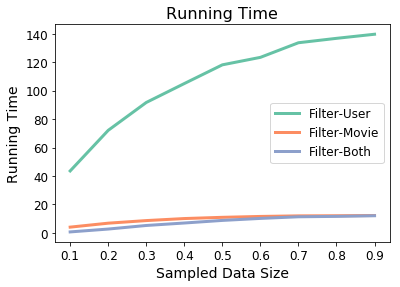

In [36]:
create_plot(size_norm_u, size_norm_m, size_norm_b, time_u, time_m, time_b, "Running Time")

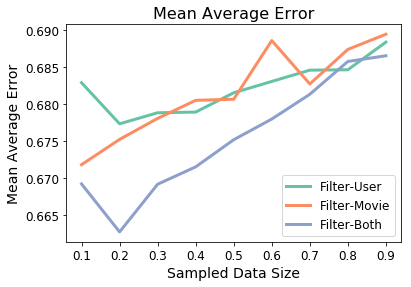

In [37]:
create_plot(size_norm_u, size_norm_m, size_norm_b, mae_u, mae_m, mae_b, "Mean Average Error")

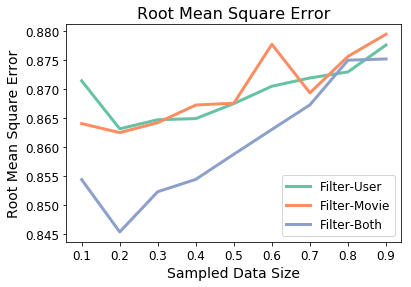

In [38]:
create_plot(size_norm_u, size_norm_m, size_norm_b, rmse_u, rmse_m, rmse_b, "Root Mean Square Error")

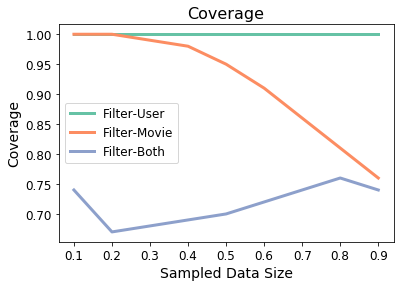

In [39]:
create_plot(size_norm_u, size_norm_m, size_norm_b, coverage_u, coverage_m, coverage_b, "Coverage")